In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve
from funcs.flarefit import aflare2

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,mission,prefix,origin,h_mission,SpT,view_start,view_stop,view_min,view_max,BJDoff,tstart,ampl_min,ampl_max
0,100004076,14,slc,kep,KIC,generic,Kepler,L1,1356.50,1361.00,600,1050,2454833,1358.550,NaN,NaN
1,212035340,18,llc,ktwo,EPIC,generic,K2,M8,3437.00,3439.50,100,900,2454833,3437.750,NaN,NaN
2,237880881,1,slc,tess,TIC,generic,TESS,M5,1331.00,1333.50,560,700,2457000,1331.700,NaN,NaN
3,44984200,10,slc,tess,TIC,custom,TESS,M6,1587.25,1589.75,1620,2200,2457000,1588.030,0.5,0.8
4,277539431,12,slc,tess,TIC,custom,TESS,M7,1641.00,1643.50,750,970,2457000,1641.835,0.9,1.7


In [4]:
target = lcs.loc[1]
target


ID            212035340
QCS                  18
typ                 llc
mission            ktwo
prefix             EPIC
origin          generic
h_mission            K2
SpT                  M8
view_start         3437
view_stop        3439.5
view_min            100
view_max            900
BJDoff          2454833
tstart          3437.75
ampl_min            NaN
ampl_max            NaN
Name: 1, dtype: object

### Load the light curve and find the median flux and standard deviation to get a sense for the noise

5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


EPIC 212035340 modulation period:  4.625968870015097 h
Relative amplitude of modulation: 5.5e-02


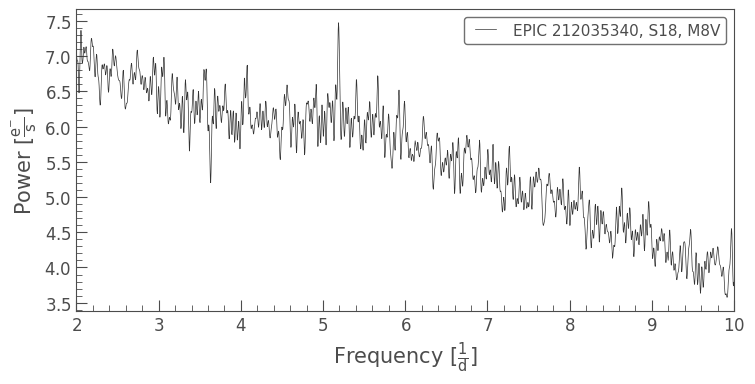

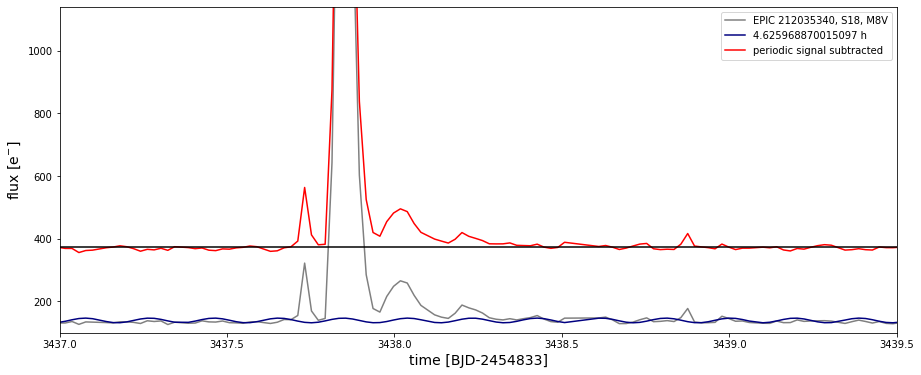

In [5]:
flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)

### Select  the part of the LC that you want to fit to. REPLACE THIS WITH DE-MODULATED FLUX

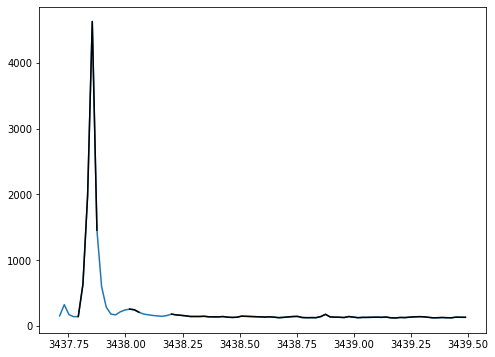

In [6]:
flc = copy.deepcopy(flck)
flc.flux[:] = sflux
median = np.nanmedian(flc.flux)
e_median = np.nanstd(flc.flux)/10.

### Select those parts of the LC that you want to use for fitting

i0, i1 = np.argmin((flc.time-target.tstart)**2)-2, np.argmin((flc.time-target.view_stop)**2)-0 #150,600 otherwise, 2,0

flc.flux_err[:] = np.nanstd(flc.flux)
flc = flc[i0:i1]
plt.figure(figsize=(8,6))
plt.plot(flc.time, flc.flux)
#a=[(0,151),(210,235),(280,310),(500,1000)]#44984200
a= [(4,9),(15,18),(23,200)]#212035340
#a = [(0,100),(400,500),(910,3200)]#100004076
#a = [(0,120),(235,800)] #237880881
#a=[(0,130),(140,150),(190,210),(330,360),(480,520),(630,660)] #277539431
for i, j in a:
    plt.plot(flc.time[i:j],flc.flux[i:j],c="k")
#plt.ylim(target.view_min,target.view_max),

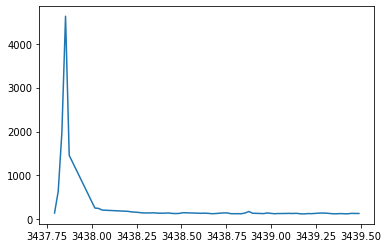

In [7]:
time = []
flux = []
flux_err = []
for i,j in a:
    time.append(flc.time[i:j])
    flux.append(flc.flux[i:j])
    flux_err.append(flc.flux_err[i:j])
time = np.array([x for sl in time for x in sl])
flux = np.array([x for sl in flux for x in sl])
flux_err = np.array([x for sl in flux_err for x in sl])
plt.plot(time, flux)


### Show the initial guess

In [1]:

# Estimate the FWHM of the flare
lower = np.where(flux < np.nanmax(flux)/2)[0] #get all indices below half maximum
maximum = np.argmax(flux) #find index of maximum
before = lower[np.where(lower < maximum)] # select indices before the maximum
after = lower[np.where(lower > maximum)] # select indices after the maximum
ts, tf = (before[np.argmin((maximum-before)**2)],
          after[np.argmin((maximum-after)**2)]) # get start and end indices into times that span one FWHM
fwhm = time[tf] - time[ts]

# Guess the parameters from crude estimates
t0i, duri, ampli = target.tstart, fwhm, np.nanmax(flux)
guess = aflare2(flc.time, t0i, duri, ampli, median) 

# Plot to see if it's reasonable
plt.figure(figsize=(14,4))
plt.errorbar(x=time, y=flux,yerr=flux_err);
plt.plot(flc.time, guess, c="k",linewidth=1);
plt.xlim(target.view_start, target.view_stop)

NameError: name 'target' is not defined

In [10]:
def log_likelihood(theta, time, flux, flux_err, median):
    """Log likelihood function assuming 
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON?
    """
    
    t0, dur, ampl = theta
    model = aflare2(time, t0, dur, ampl, median)
    val = -0.5 * np.sum((flux - model) ** 2 / flux_err**2 + np.log(flux_err**2))
    return val


def log_prior(theta, x):
    """Uniform prior for start time,
    amplitude, and duration.
    
    - Start time shoud lie approximately 
      within the observation time.
    - Duration always positive.
    - Amplitude always positive.
    
    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    t0, dur, ampl= theta
    if x[0]-50 < t0 < x[-1] and 0.0 < dur and 0 < ampl:
        return 0.0
    return -np.inf

def log_probability(theta, time, flux, flux_err, median):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(theta, time)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta, time, flux, flux_err, median)

Maximum likelihood estimates:
t0 = 3437.841
dur = 0.026
ampl = 11900.952


(3437.7931559269346, 3439.488997790191)

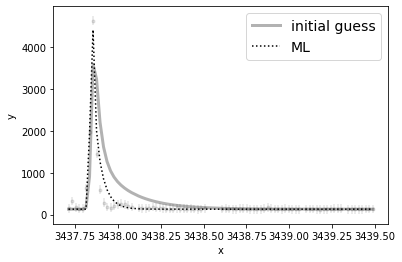

In [11]:
def get_ML_fit(log_likelihood, args, inits):
    nll = lambda *args: -log_likelihood(*args)
    soln = optimize.minimize(nll, inits, args=args)
    t0_ml, dur_ml, ampl_ml = soln.x

    # Stdout
    print("Maximum likelihood estimates:")
    print(f"t0 = {t0_ml:0:.3f}")
    print(f"dur = {dur_ml:0:.3f}")
    print(f"ampl = {ampl_ml:.3f}")
    print("---------------------------------------")
    print("Message from scipy.optimize.minimize:\n")
    print(soln.message)
    return t0_ml, dur_ml, ampl_ml
    
t0_ml, dur_ml, ampl_ml = get_ML_fit(log_likelihood,
                                    args=(time, flux, flux_err, median),
                                    inits=np.array([t0i, duri, ampli]),)

def plot_ML_fit(target, model, results):
    flc = fetch_lightcurve(target)
    plt.figure(figsize=(8,6))
    # Plot the original flux
    plt.errorbar(flc.time, flc.flux, yerr=flc.flux_err, fmt=".k", capsize=0, alpha=.1)

    # Plot 
    plt.plot(flc.time,aflare2(flc.time, t0_ml, dur_ml, ampl_ml,median), ":k", label="ML")
    plt.legend(fontsize=14)
    plt.xlabel("")
    plt.ylabel("y");

In [12]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
#pos = initial + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err, median))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:18<00:00, 276.77it/s]


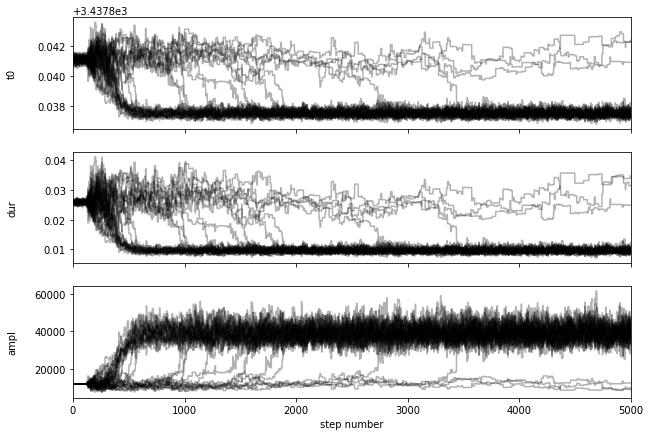

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "dur", "ampl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


(2112, 3)


Too few points to create valid contours


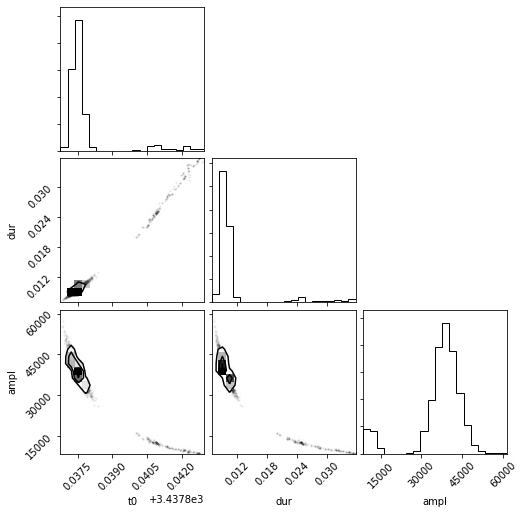

In [14]:
import corner
flat_samples = sampler.get_chain(discard=4000, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[t0i,duri,ampli]);

No handles with labels found to put in legend.


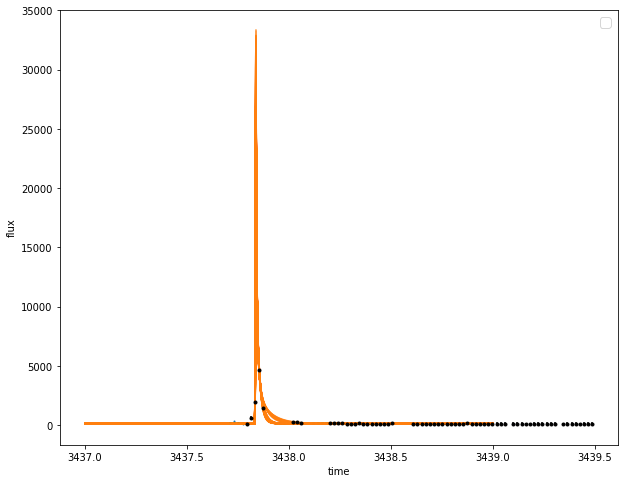

In [25]:
inds = np.random.randint(len(flat_samples), size=300)
plt.figure(figsize=(10,8))
t_ = np.linspace(3437,3439,800)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(t_, aflare2(t_, *sample[:3], median), "C1", alpha=0.5)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", capsize=0)
plt.scatter(flc.time, flc.flux, s=1)
#plt.plot(flc.time, truth, "k", label="init gues", linewidth=1)
plt.legend(fontsize=14)
#plt.xlim(10, 13)
plt.xlabel("time")
plt.ylabel("flux");
#plt.xlim(3437.5,3438)

In [255]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

((3437.8374970212835, 0.00036496117445494747, 0.00021988847583997995),
 (0.009657598797035209, 0.001323971557120402, 0.0007805810463988767),
 (38517.094975853615, 4830.148687847985, 6041.707816237333))

In [256]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [257]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [258]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

(483655.2681379847,
 32800122562.880383,
 99748930639.90837,
 76086766611.86272,
 25286598582.974373)

In [259]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

(10.512526702880859, 129.2186)

In [260]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

(1954494.1410586142, 483655.2681379847)

In [261]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)